In [ ]:
!git clone https://github.com/twpkevin06222/Liver-Segmentation-Project-.git medical_imaging

fatal: destination path 'medical_imaging' already exists and is not an empty directory.


In [ ]:
!pip install nibabel

In [ ]:
import h5py
import os
import cv2
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading nifti images
import math
import glob
import matplotlib.pyplot as plt
%matplotlib inline
#from read_data import load_images
from keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import directed_hausdorff

In [ ]:
import tensorflow as tf
import keras
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Tensorflow version: 2.12.0
Keras version: 2.12.0


In [ ]:
def three_to_two(path, label='FALSE'):
    ff = sorted(glob.glob(path))
    images =[]
    for f in range(len(ff)):
        a = nib.load(ff[f])
        a = a.get_data()
        for i in range(a.shape[2]):
            images.append(a[:,:,i])
    images = np.asarray(images)
    #images = images.reshape(-1, 128,128, 1) # dimension to feed into the network
    return images

def min_max_norm(images):
    m = np.max(images)
    mi = np.min(images)
    images = (images - mi)/ (m - mi)
    return images

def label_outliers(img_labels):
    img_labels[img_labels>1]=1
    img_labels[img_labels<0]=0
    return img_labels

#Image for training
images = three_to_two(path='medical_imaging/tmp/tmp_img/img_new/*')
x_data = min_max_norm(images)

#labels
img_labels = three_to_two(path='medical_imaging/tmp/tmp_img/img_new_label/*')
y_data = label_outliers(img_labels)

#Test Image
img_test = three_to_two(path='medical_imaging/tmp/tmp_img/test_img/*')
x_test = min_max_norm(img_test)

#Test Labels
label_test = three_to_two(path='medical_imaging/tmp/tmp_img/test_img_label/*')
y_test = label_outliers(label_test)

<ipython-input-10-281133919471>:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  a = a.get_data()


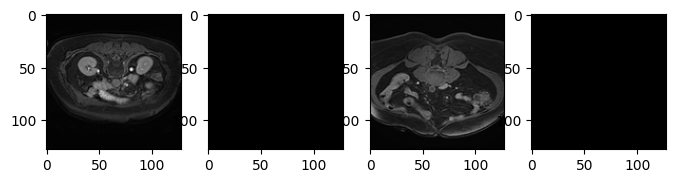

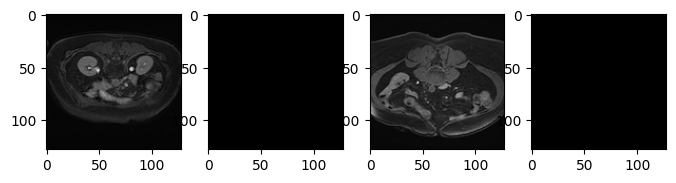

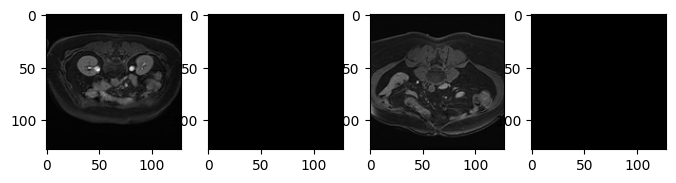

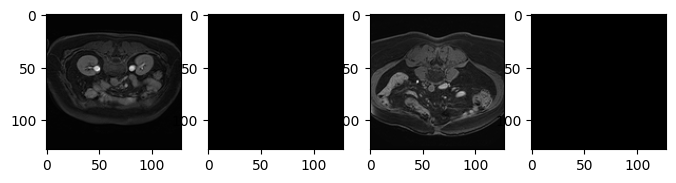

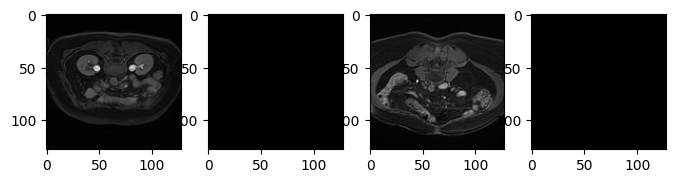

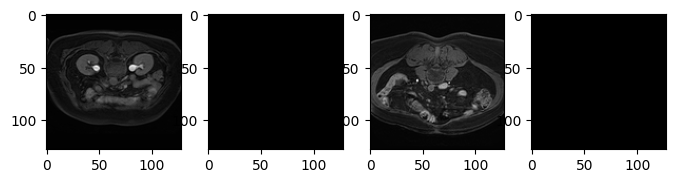

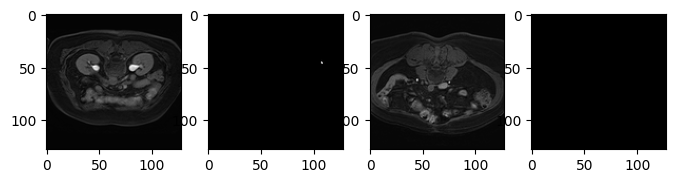

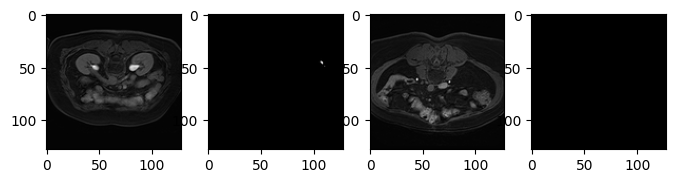

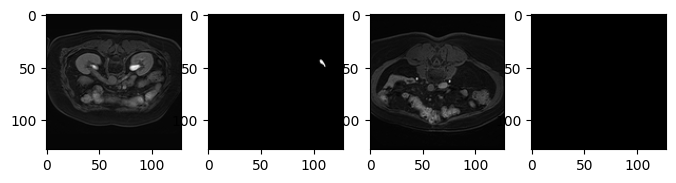

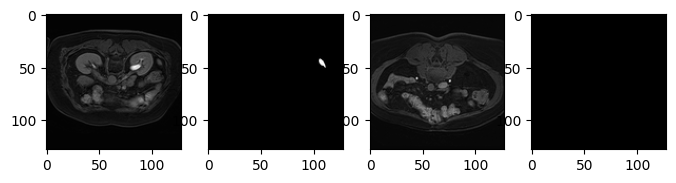

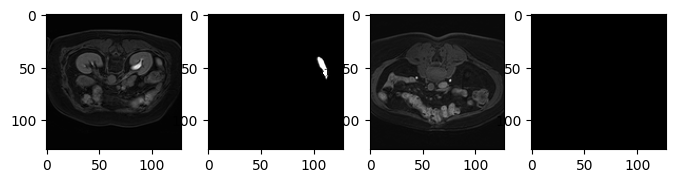

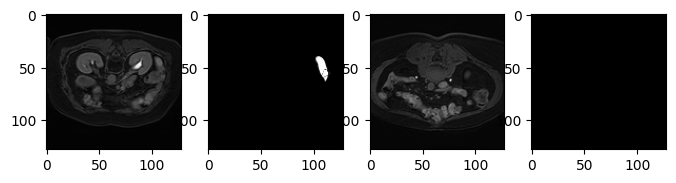

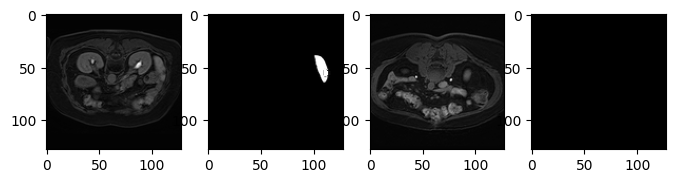

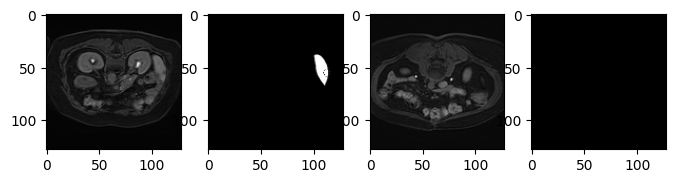

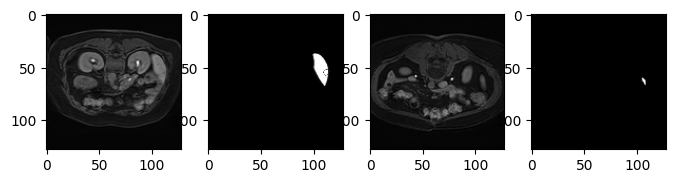

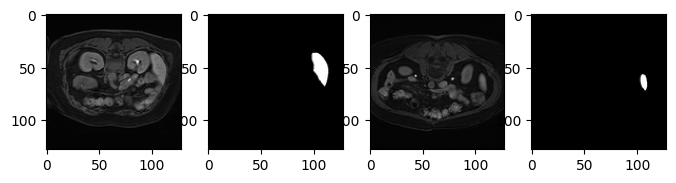

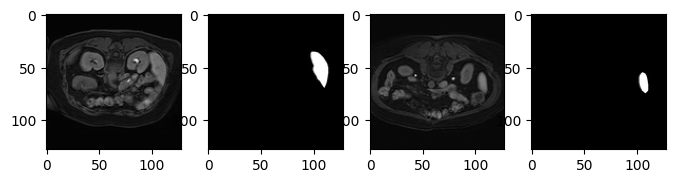

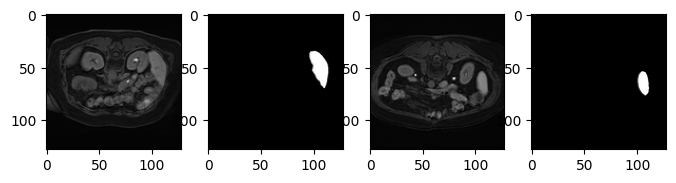

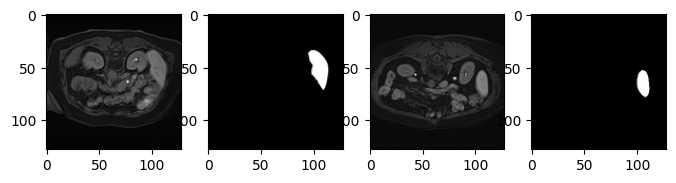

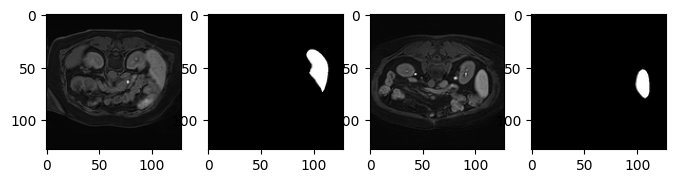

In [ ]:
#show 1st 20 slices with noisy y_data_noisy
for i in range(20):
    fig, ax = plt.subplots(1,4, figsize = (8,4))
    ax[0].imshow(x_data[i], cmap='gray')
    ax[1].imshow(y_data[i], cmap='gray') # Use y_data_noisy here to show the noisy labels
    ax[2].imshow(x_test[i], cmap='gray')
    ax[3].imshow(y_test[i], cmap='gray')

plt.show()

In [ ]:
x_data = x_data[:,:,:,np.newaxis] # same as reshape (-1,128,128,1)
y_data = y_data[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]
y_test = y_test[:,:,:,np.newaxis]

print('Dimension for training data:', x_data.shape)
print('Dimension for training data labels:', y_data.shape)
print('Dimension for test data:', x_test.shape)
print('Dimension for test data labels:', y_test.shape)

Dimension for training data: (3036, 128, 128, 1)
Dimension for training data labels: (3036, 128, 128, 1)
Dimension for test data: (735, 128, 128, 1)
Dimension for test data labels: (735, 128, 128, 1)


In [ ]:
from sklearn.utils import shuffle

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, random_state =42)
x_test, y_test = shuffle(x_test, y_test, random_state= 42)

In [ ]:
import keras.backend as K
import tensorflow as tf

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (total_positives + K.epsilon())

def hausdorff_distance(y_true, y_pred):
    surface_distances = tf.reduce_sum(y_true * y_pred, axis=[1, 2]) / tf.reduce_sum(y_true + y_pred, axis=[1, 2])
    hausdorff_distance = tf.reduce_max(surface_distances)
    return hausdorff_distance

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    total_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (total_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (total_positives + K.epsilon())


def top_k_loss(y_true, y_pred, k=1):
    # Get the top-k predictions for each sample
    top_k_values, top_k_indices = tf.math.top_k(y_pred, k=k)

    # Convert y_true to one-hot encoding
    y_true_onehot = K.one_hot(K.argmax(y_true, axis=-1), num_classes=K.int_shape(y_pred)[-1])

    # Calculate the Top-K Loss
    loss = K.sum(y_true_onehot - top_k_values, axis=-1)

    return K.mean(loss)



In [ ]:
input_layer = Input(shape=x_train.shape[1:]) #Input(shape = (x, y, inChannel))

In [ ]:
def conv_block(x_in, filters, batch_norm, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_2d(x_in, filters, batch_norm, kernel_size=(3,3),acti ='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x=BatchNormalization()(x)
    x= Activation(acti)(x)
    return x

def pool(x_in, pool_size=(2, 2), type='Max'):
    if type=='Max':
        p = MaxPooling2D(pool_size)(x_in)
    return p

def up(x_in, filters, merge, batch_norm, size=(2,2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_block(u, filters, batch_norm)
    merge=concatenate([merge, conv],axis=-1)
    return merge

def Unet_01(input_layer):
    conv1 = conv_block(input_layer, filters=16, batch_norm='TRUE')
    pool1 = pool(conv1)

    conv2 = conv_block(pool1, filters=32, batch_norm='TRUE')
    pool2 = pool(conv2)

    conv3 = conv_block(pool2, filters=32, batch_norm='TRUE')
    pool3 = pool(conv3)

    conv4 = conv_block(pool3, filters=64, batch_norm='TRUE')
    pool4 = pool(conv4)

    conv5 = conv_2d(pool4, filters=128, batch_norm='TRUE')

    up1 = up(conv5,filters=128, merge=conv4, batch_norm='TRUE')
    conv6 = conv_2d(up1, filters=128, batch_norm='TRUE')

    up2 = up(conv6, filters=128, merge=conv3, batch_norm='TRUE')
    conv7 = conv_2d(up2, filters=128, batch_norm='TRUE')

    up3 = up(conv7, filters=64, merge=conv2, batch_norm='TRUE')
    conv8 = conv_2d(up3, filters=64, batch_norm='TRUE')

    up4 = up(conv8, filters=32, merge=conv1, batch_norm='TRUE')
    conv9 = conv_2d(up4, filters=32, batch_norm='TRUE')

    conv10 = conv_2d(conv9, filters=1, batch_norm='FALSE', acti='sigmoid')

    output_layer = conv10
    model = Model(input_layer, output_layer)

    return model

In [ ]:
model = Unet_01(input_layer)

In [ ]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=42)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=42)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

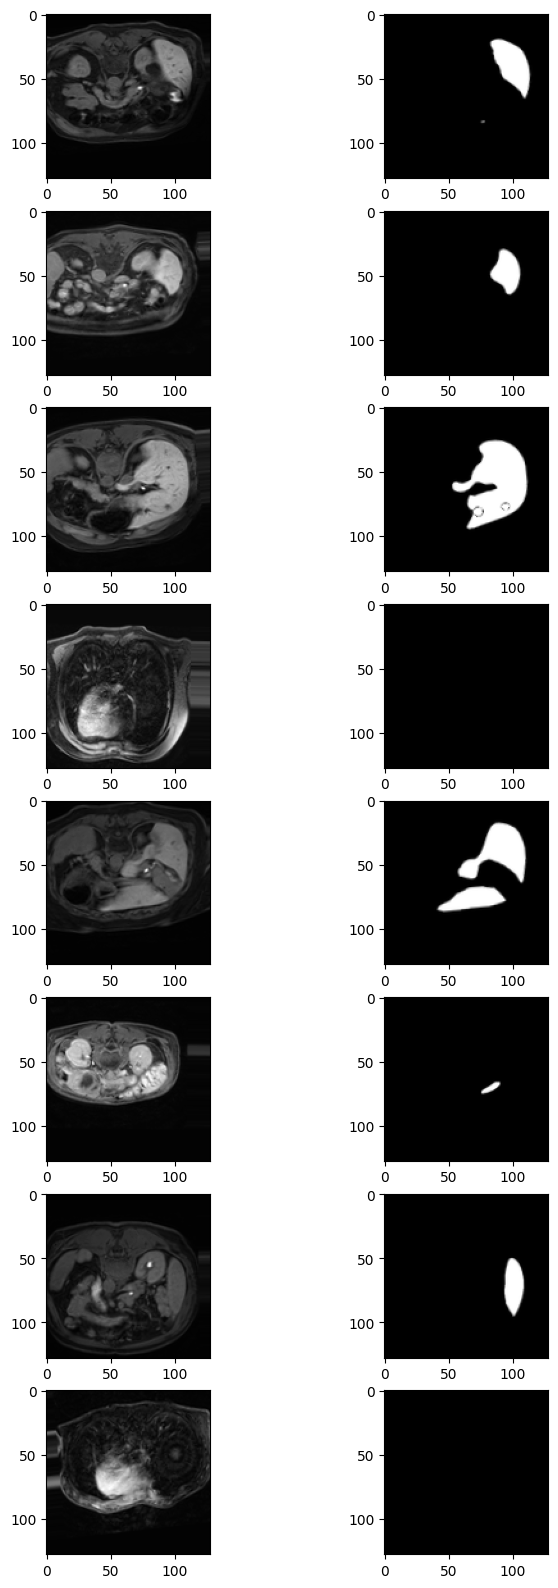

In [ ]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0], cmap='gray')
plt.show()

In [ ]:
model.compile(optimizer=Adam(1e-4), loss= top_k_loss, metrics=[dice_coef,jaccard_index,hausdorff_distance,precision,recall,specificity,sensitivity])

In [ ]:
# def steps_per_epoch(sample, batch_size):
#     a = int(np.floor(sample/batch_size))
#     if a<200:
#         return 200
#     else:
#         return a

sample = len(x_data)
batch_size = 64
epochs = 20
steps_per_epoch = 200
#steps_per_epoch = int(np.floor(sample/batch_size))
#steps_per_epoch = steps_per_epoch(sample, batch_size)

print('Step per epoch: ', steps_per_epoch)

Step per epoch:  200


In [ ]:
from keras.callbacks import LearningRateScheduler
weight_saver = ModelCheckpoint('seg.h5', monitor='val_dice_coef',
                                              save_best_only=True, save_weights_only=True)

lr_decay = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [ ]:
from keras.callbacks import TensorBoard
import time

model_dir = 'logs/{}'.format(time.strftime("%H"+"%M"))
tensorboard = TensorBoard(log_dir= model_dir, histogram_freq=epochs, batch_size=batch_size, write_graph=True,
                          write_grads=False, write_images=True, embeddings_freq=0,
                          embeddings_layer_names=None, embeddings_metadata=None,
                          embeddings_data=None, update_freq='epoch')

write_time = time.strftime("%H"+"%M")

In [ ]:
hist = model.fit_generator(my_generator(x_train, y_train, batch_size),
                           steps_per_epoch = steps_per_epoch,
                           validation_data = (x_val, y_val),
                           epochs=epochs, verbose=1,
                           callbacks = [weight_saver, lr_decay])

<ipython-input-24-714d6c19448a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(my_generator(x_train, y_train, batch_size),


Epoch 1/20
200/200 [==============================] - 345s 2s/step - loss: 0.0199 - dice_coef: 0.1176 - jaccard_index: 0.0625 - hausdorff_distance: 0.1770 - precision: 0.0625 - recall: 0.9907 - specificity: 0.0047 - sensitivity: 0.9907 - val_loss: 0.0018 - val_dice_coef: 0.1216 - val_jaccard_index: 0.0649 - val_hausdorff_distance: 0.1641 - val_precision: 0.0648 - val_recall: 0.9999 - val_specificity: 0.0000e+00 - val_sensitivity: 0.9999 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 315s 2s/step - loss: 6.6484e-04 - dice_coef: 0.1171 - jaccard_index: 0.0622 - hausdorff_distance: 0.1771 - precision: 0.0623 - recall: 1.0000 - specificity: 0.0000e+00 - sensitivity: 1.0000 - val_loss: 4.7842e-04 - val_dice_coef: 0.1216 - val_jaccard_index: 0.0648 - val_hausdorff_distance: 0.1641 - val_precision: 0.0648 - val_recall: 0.9999 - val_specificity: 0.0000e+00 - val_sensitivity: 0.9999 - lr: 8.0000e-04
Epoch 3/20
200/200 [==============================] - 315s 2s/step - loss: 3

In [ ]:
model.load_weights('seg.h5')

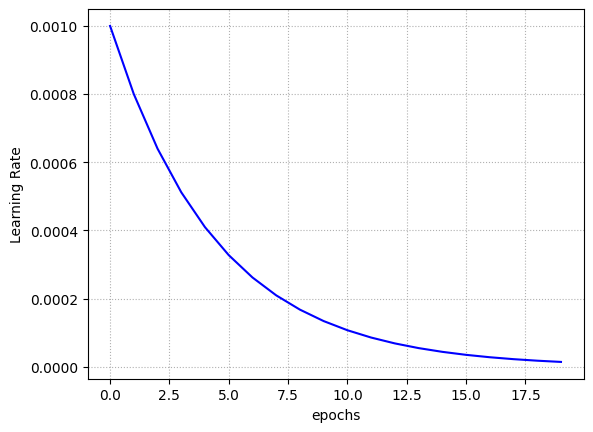

In [ ]:
plt.plot(hist.history['lr'], color='b')
plt.xlabel("epochs")
plt.ylabel("Learning Rate")
plt.grid(linestyle='dotted')
plt.show()

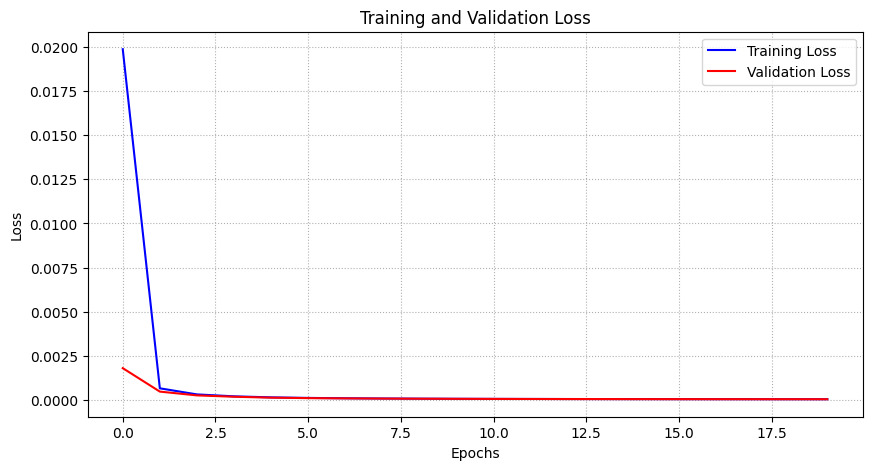

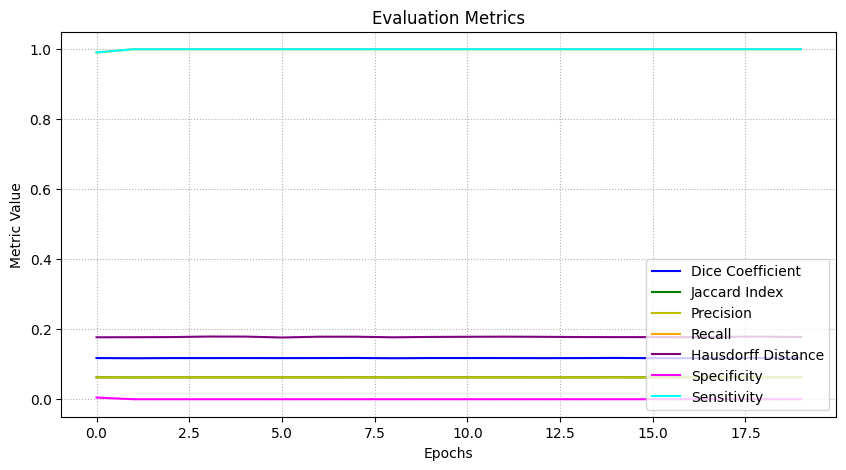

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the history dictionary that contains the metric values during training
# hist = model.fit(...)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(linestyle='dotted')
plt.title("Training and Validation Loss")
plt.show()

# Plot Metrics
plt.figure(figsize=(10, 5))
plt.plot(hist.history['dice_coef'], color='b', label='Dice Coefficient')
plt.plot(hist.history['jaccard_index'], color='g', label='Jaccard Index')
plt.plot(hist.history['precision'], color='y', label='Precision')
plt.plot(hist.history['recall'], color='orange', label='Recall')
plt.plot(hist.history['hausdorff_distance'], color='purple', label='Hausdorff Distance')
plt.plot(hist.history['specificity'], color='magenta', label='Specificity')
plt.plot(hist.history['sensitivity'], color='cyan', label='Sensitivity')

plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.legend(loc='lower right')
plt.grid(linestyle='dotted')
plt.title("Evaluation Metrics")
plt.show()


In [ ]:
# To run tensorboard
print('To view tensorboard, put this in your command line: \n tensorboard --log=logs/{}/'.format(write_time))

To view tensorboard, put this in your command line: 
 tensorboard --log=logs/1006/


In [ ]:
!rm -rf ngrok-stable-linux-amd64.zip
!rm -rf ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
#!rm -f log/*   # Delete this if you want to keep the logs of the old runs
LOG_DIR = 'logs/{}'.format(write_time)
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2023-07-06 11:53:56--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  19.3MB/s    in 0.7s    

2023-07-06 11:53:57 (19.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj

In [ ]:
# Assuming you have already defined the evaluation functions as mentioned in previous interactions

# Evaluating the model on the test dataset
test_eval = model.evaluate(x_test, y_test, verbose=1, batch_size=batch_size)

# Extracting individual metrics from the test evaluation
test_loss = test_eval[0]
test_dice_coef = test_eval[1]
test_jaccard_index = jaccard_index(y_test, model.predict(x_test))
test_precision = precision(y_test, model.predict(x_test))
test_recall = recall(y_test, model.predict(x_test))
test_hausdorff_distance = hausdorff_distance(y_test, model.predict(x_test))
test_specificity = specificity(y_test, model.predict(x_test))
test_sensitivity = sensitivity(y_test, model.predict(x_test))

# Printing the evaluation results
print('Test loss:', test_loss)
print('Test Dice Coefficient:', test_dice_coef)
print('Test Jaccard Index:', test_jaccard_index)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Hausdorff Distance:', test_hausdorff_distance)
print('Test Specificity:', test_specificity)
print('Test Sensitivity:', test_sensitivity)

23/23 [==============================] - 1s 43ms/step
Test loss: 3.9246922824531794e-05
Test Dice Coefficient: 0.10606595873832703
Test Jaccard Index: tf.Tensor(0.05613132, shape=(), dtype=float32)
Test Precision: tf.Tensor(0.056130838, shape=(), dtype=float32)
Test Recall: tf.Tensor(0.9999926, shape=(), dtype=float32)
Test Hausdorff Distance: tf.Tensor(0.15953216, shape=(), dtype=float32)
Test Specificity: tf.Tensor(0.0, shape=(), dtype=float32)
Test Sensitivity: tf.Tensor(0.9999926, shape=(), dtype=float32)


23/23 [==============================] - 1s 43ms/step


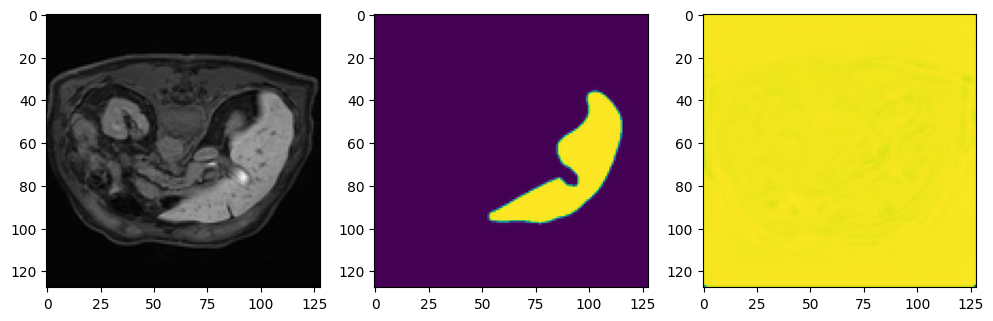

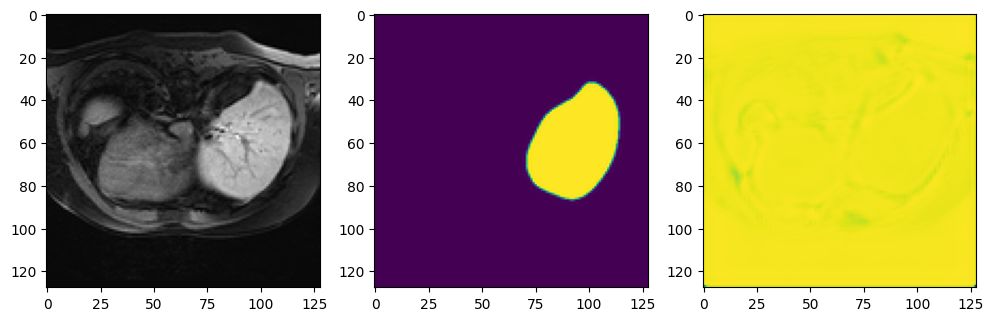

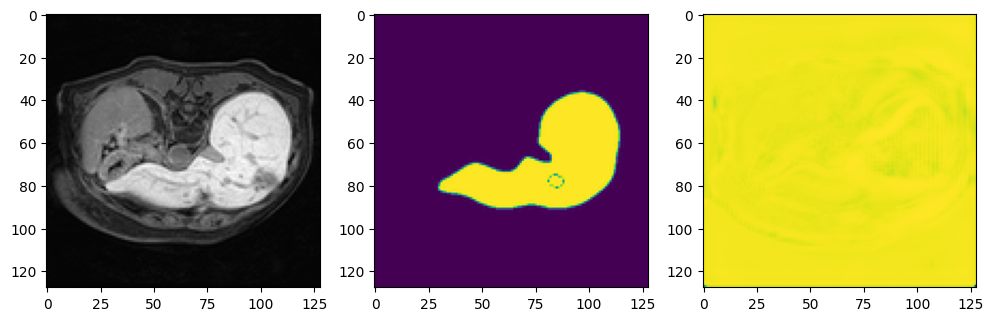

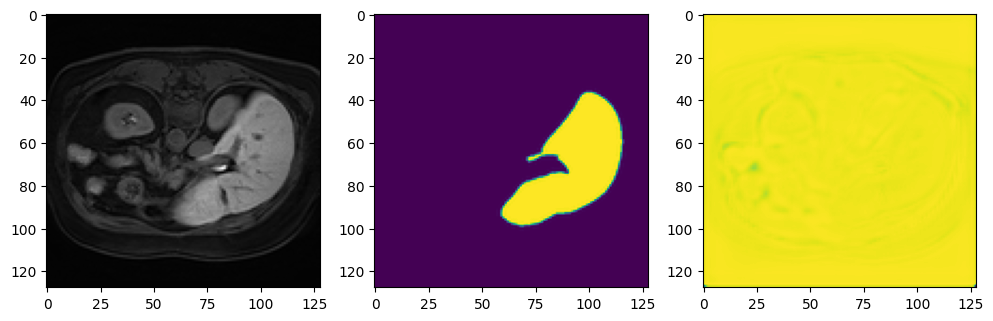

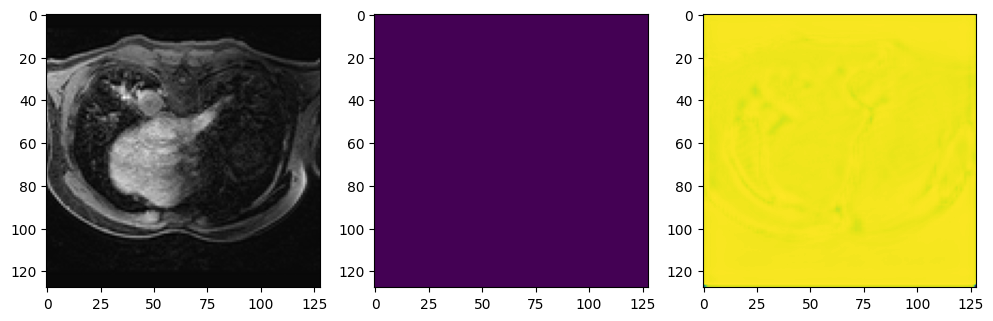

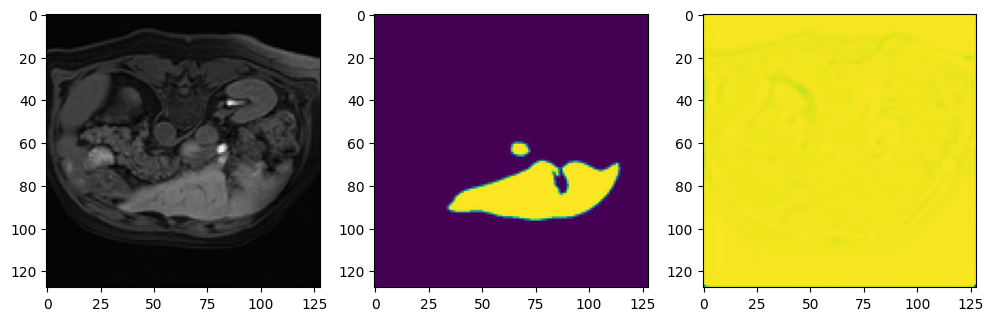

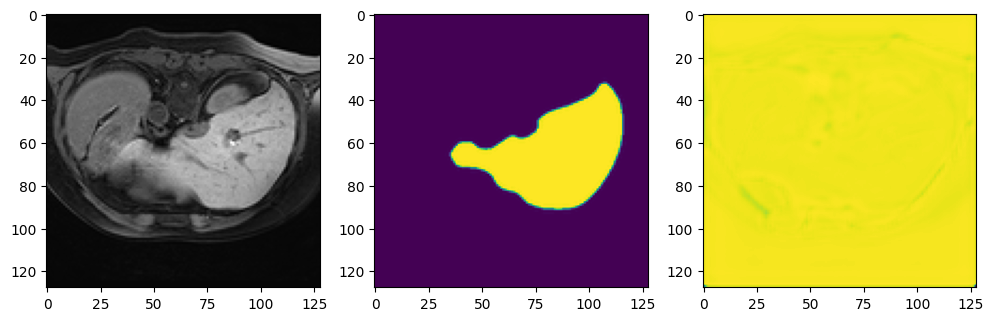

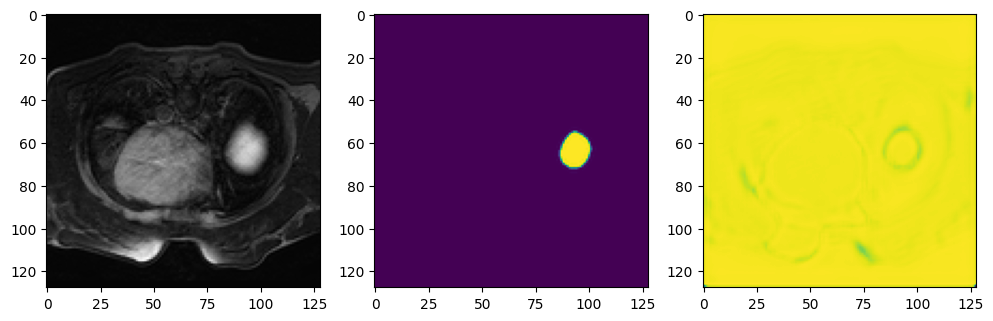

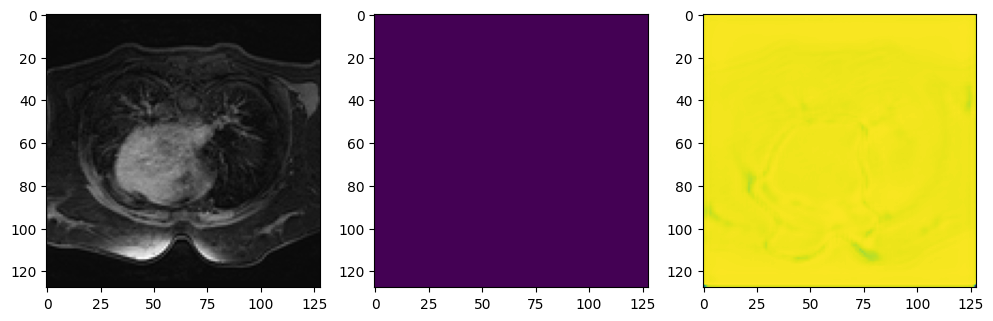

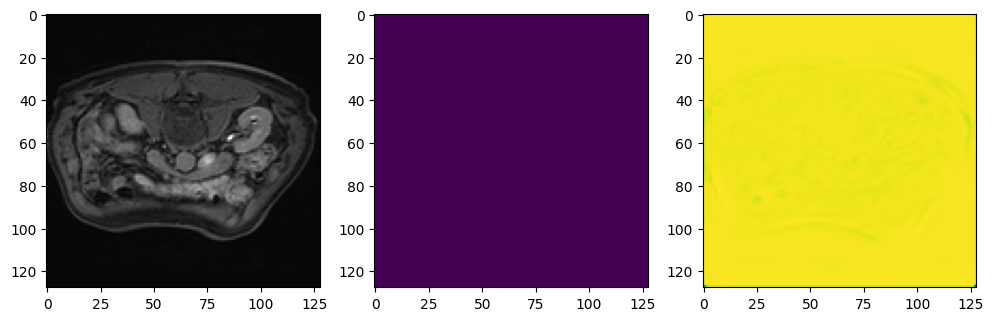

In [ ]:
y_pred = model.predict(x_test)
for i in range(0,20,2):
    fig, ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].imshow(x_test[i,:,:,0], cmap='gray')
    ax[1].imshow(y_test[i,:,:,0], cmap='viridis')
    ax[2].imshow(y_pred[i,:,:,0], cmap='viridis')
plt.show()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             